In [1]:
!pip install gradio==3.50.2 ipywidgets==8.1.1

Defaulting to user installation because normal site-packages is not writeable


In [1]:
from PIL import Image
import requests
from transformers import SamModel, SamProcessor
from diffusers import DiffusionPipeline, AutoPipelineForText2Image, AutoPipelineForInpainting
from diffusers.utils import load_image, make_image_grid

import torch
import numpy as np

In [2]:
model = SamModel.from_pretrained("facebook/sam-vit-base").to("cuda")
processor = SamProcessor.from_pretrained("facebook/sam-vit-base")

pipeline = AutoPipelineForInpainting.from_pretrained(
    "diffusers/stable-diffusion-xl-1.0-inpainting-0.1", torch_dtype=torch.float16
)
pipeline.enable_model_cpu_offload()

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

The config attributes {'decay': 0.9999, 'inv_gamma': 1.0, 'min_decay': 0.0, 'optimization_step': 37000, 'power': 0.6666666666666666, 'update_after_step': 0, 'use_ema_warmup': False} were passed to UNet2DConditionModel, but are not expected and will be ignored. Please verify your config.json configuration file.


In [3]:
def get_processed_inputs(image, input_points):
    
    inputs = processor(
       image, 
       input_points=input_points,
       return_tensors="pt"
    ).to("cuda")
    
    outputs = model(**inputs)

    masks = processor.image_processor.post_process_masks(
       outputs.pred_masks.cpu(), 
       inputs["original_sizes"].cpu(), 
       inputs["reshaped_input_sizes"].cpu()
    )
    
    best_mask = masks[0][0][outputs.iou_scores.argmax()]
    
    bg_transparent = np.zeros(best_mask.shape + (4, ), dtype=np.uint8)
    bg_transparent[best_mask == 0] = [0, 255, 0, 127]  

    
    return bg_transparent


def inpaint(raw_image, input_mask, prompt, negative_prompt=None, seed=74294536, cfgs=7):
    
    mask_image = Image.fromarray(input_mask)
    rand_gen = torch.manual_seed(seed)
    image = pipeline(
        prompt=prompt, 
        negative_prompt=negative_prompt, 
        image=raw_image, 
        mask_image=mask_image, 
        generator=rand_gen, 
        guidance_scale=cfgs
    ).images[0]
    
    return image

In [4]:
img_url = "https://huggingface.co/ybelkada/segment-anything/resolve/main/assets/car.png"
raw_image = Image.open(requests.get(img_url, stream=True).raw).convert("RGB").resize((1024, 1024))

input_points = [[[150 * 2, 170 * 2], [300 * 2, 250 * 2]]] # 2D localization of a window

mask = get_processed_inputs(raw_image, input_points)

# prompt = "a car stuck in traffic in New York on a rainy day"
# prompt = "a car driving on the beach in broad daylight"
prompt = "a car driving on the Mars. Studio lights, 1970s"
negative_prompt = "artifacts, low quality, distortion"

image = inpaint(raw_image, mask, prompt, negative_prompt)

  0%|          | 0/49 [00:00<?, ?it/s]

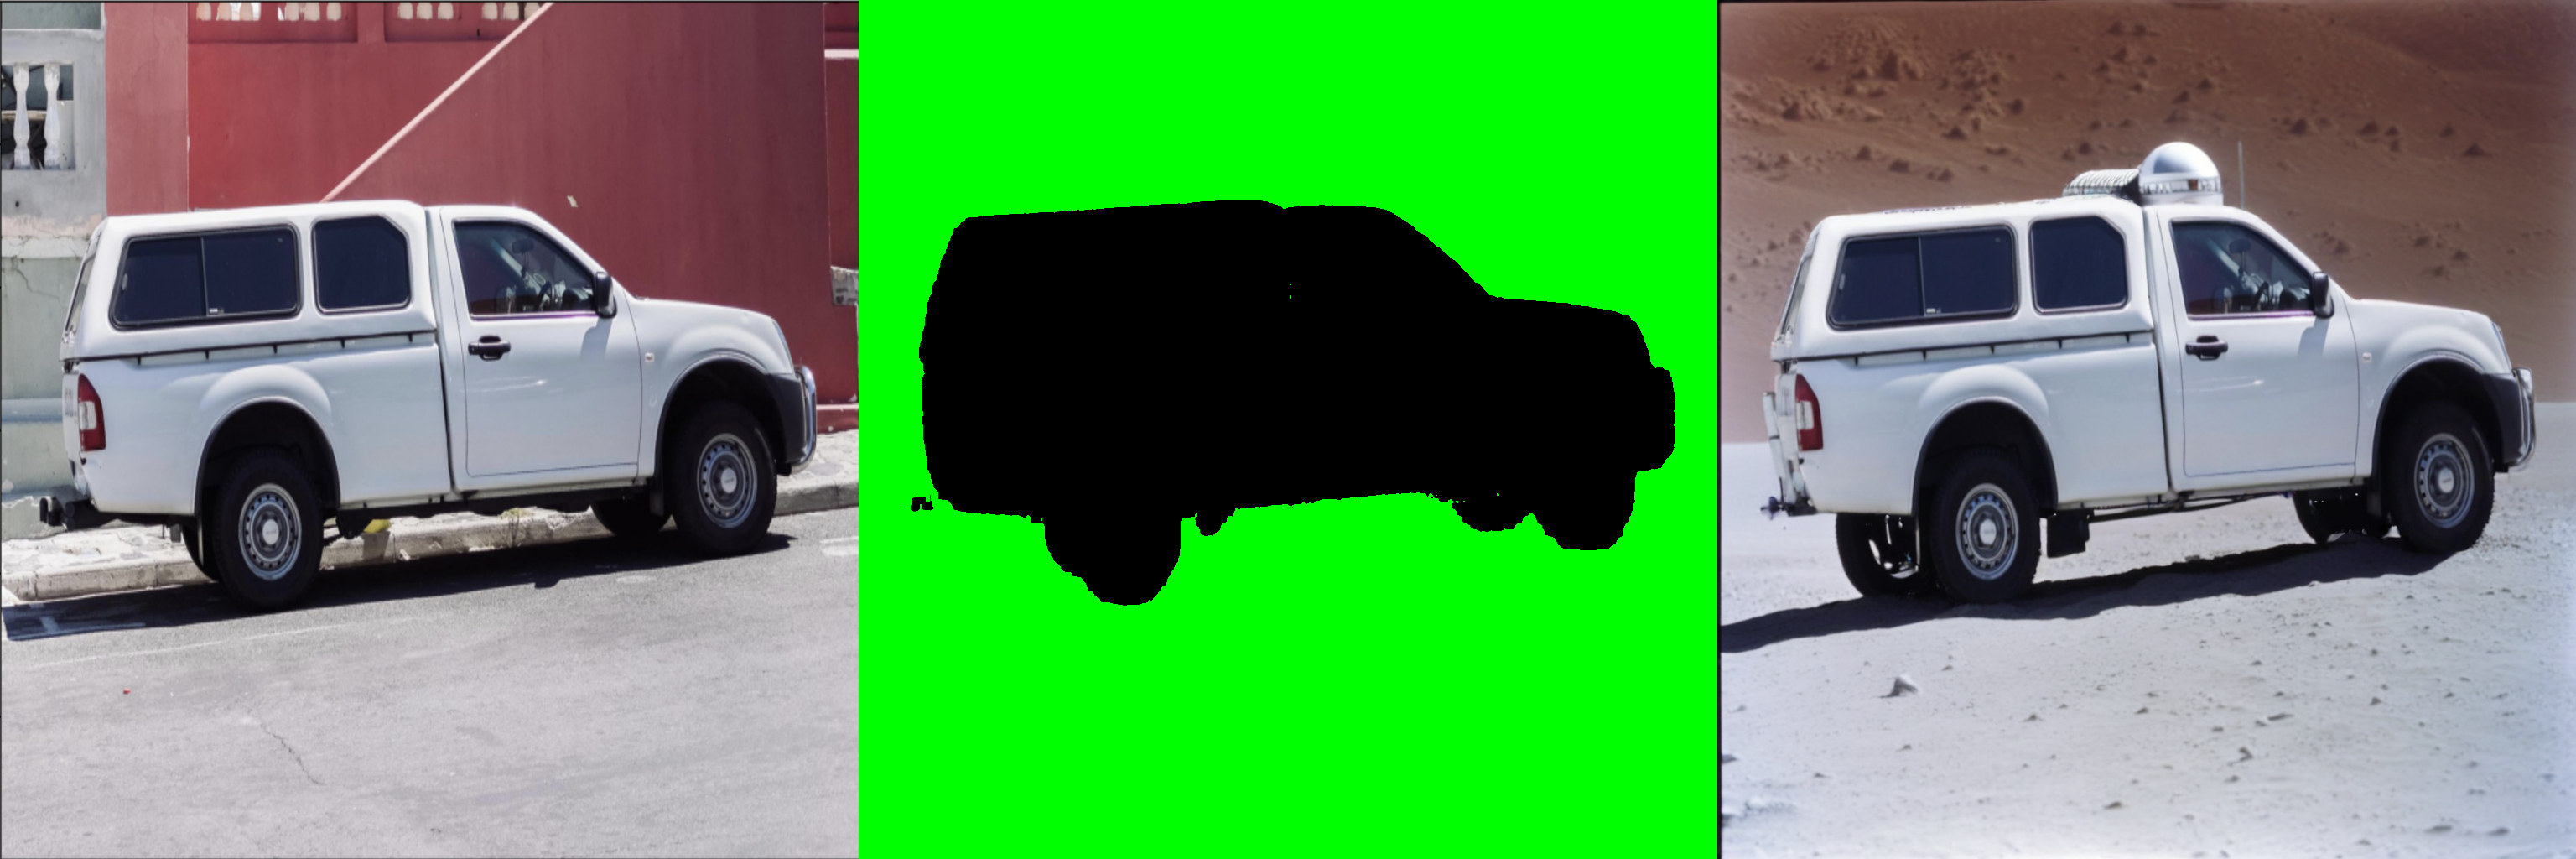

In [5]:
fig = make_image_grid([raw_image, Image.fromarray(mask), image], rows=1, cols=3)
fig

In [5]:
import gradio as gr
import numpy as np
from PIL import Image

HEIGHT = 256
WIDTH = 256

input_points = []

def get_points(img, evt: gr.SelectData):

    x = evt.index[0]
    y = evt.index[1]
    
    input_points.append([x, y])
    
    print(f"Added {x}, {y}")


def run_sam(raw_image):
    global input_points
    
    if len(input_points) == 0:
        raise gr.Error("No points provided. Click on the image to select the object to segment with SAM")
    
    print(f"Received {len(input_points)} points")
    print("Processing input image with SAM...")
    mask = get_processed_inputs(raw_image, [input_points])
    
    input_points = []
    
    return mask


def run(raw_image, mask, prompt, negative_prompt, cfg, seed):
    
    # prompt = "a car stuck in traffic in New York on a rainy day"
    # prompt = "a car driving on the beach in broad daylight"
    # prompt = "a car driving on the Mars. Studio lights, 1970s"
    # negative_prompt = "artifacts, low quality, distortion"
    
    print(f"Prompt: {prompt}")
    print(f"Negative prompt: {negative_prompt}")
    
    print("Inpainting...")
    inpainted = inpaint(raw_image, np.array(mask), prompt, negative_prompt, seed, cfg)
    print("done!")
    return inpainted


with gr.Blocks() as demo:
    with gr.Row():
        input_img = gr.Image(
            label="Input", 
            interactive=True, 
            type='pil',
            height=HEIGHT,
            width=WIDTH
        )
        input_img.select(get_points, inputs=[input_img])
                
        sam_mask = gr.Image(
            label="SAM result",
            interactive=False,
            type='pil',
            height=HEIGHT,
            width=WIDTH,
            elem_id="sam_mask"
        )
                
        result = gr.Image(
            label="Output",
            interactive=False,
            type='pil',
            height=HEIGHT,
            width=WIDTH,
            elem_id="output_image"
        )
    
    with gr.Row():
        cfg = gr.Slider(
            label="Classifier-Free Guidance Scale", minimum=0.0, maximum=20.0, value=7, step=0.05
        )
        random_seed = gr.Number(
            label="Random seed", 
            value=74294536, 
            precision=0
        )
    
    with gr.Row():
        prompt = gr.Textbox(
            label="Prompt for infill"
        )
        neg_prompt = gr.Textbox(
            label="Negative prompt"
        )
        submit_sam = gr.Button(value="run SAM")
        submit_inpaint = gr.Button(value="run inpaint")
    
    with gr.Row():
        examples = gr.Examples(
            [
                [
                    "car.png", 
                    "a car driving on the Mars. Studio lights, 1970s", 
                    "artifacts, low quality, distortion",
                    74294536
                ],
                [
                    "dragon.jpeg",
                    "a dragon in a medieval village",
                    "artifacts, low quality, distortion",
                    97
                ],
                [
                    "monalisa.png",
                    "a fantasy landscape with flying dragons",
                    "artifacts, low quality, distortion",
                    97
                ]
            ],
            inputs=[
                input_img,
                prompt,
                neg_prompt,
                random_seed
            ]
            
        )
    
    submit_sam.click(
        fn=run_sam,
        inputs=[input_img],
        outputs=[sam_mask]
    )
    
    submit_inpaint.click(
        fn=run, 
        inputs=[
            input_img, 
            sam_mask,
            prompt, 
            neg_prompt,
            cfg,
            random_seed
        ], 
        outputs=[result]
    )

demo.queue().launch(share=True)

Running on local URL:  http://127.0.0.1:7861
Running on public URL: https://8afa095fe7f752416e.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)


Traceback (most recent call last):
  File "/home/student/.local/lib/python3.10/site-packages/gradio/queueing.py", line 407, in call_prediction
    output = await route_utils.call_process_api(
  File "/home/student/.local/lib/python3.10/site-packages/gradio/route_utils.py", line 226, in call_process_api
    output = await app.get_blocks().process_api(
  File "/home/student/.local/lib/python3.10/site-packages/gradio/blocks.py", line 1550, in process_api
    result = await self.call_function(
  File "/home/student/.local/lib/python3.10/site-packages/gradio/blocks.py", line 1185, in call_function
    prediction = await anyio.to_thread.run_sync(
  File "/home/student/.local/lib/python3.10/site-packages/anyio/to_thread.py", line 33, in run_sync
    return await get_asynclib().run_sync_in_worker_thread(
  File "/home/student/.local/lib/python3.10/site-packages/anyio/_backends/_asyncio.py", line 877, in run_sync_in_worker_thread
    return await future
  File "/home/student/.local/lib/python3.

Added 304, 481
Added 511, 560
Added 497, 195
Added 788, 499
Added 607, 794
Added 453, 776
Received 6 points
Processing input image with SAM...
Prompt: a dragon in a medieval village
Negative prompt: artifacts, low quality, distortion
Inpainting...


  0%|          | 0/49 [00:00<?, ?it/s]

done!
Added 275, 453
Added 332, 270
Added 295, 176
Added 289, 267
Added 255, 270
Received 5 points
Processing input image with SAM...
Added 266, 167
Added 358, 184
Added 361, 284
Added 298, 259
Added 260, 273
Added 275, 459
Added 364, 499
Added 375, 407
Received 8 points
Processing input image with SAM...
Prompt: a man, oil painting, renaissance, Da Vinci
Negative prompt: artifacts, low quality, distortion
Inpainting...


  0%|          | 0/49 [00:00<?, ?it/s]

done!
Prompt: a fantasy landscape with flying dragons
Negative prompt: artifacts, low quality, distortion
Inpainting...


  0%|          | 0/49 [00:00<?, ?it/s]

done!
Prompt: a fantasy landscape with flying dragons
Negative prompt: artifacts, low quality, distortion
Inpainting...


  0%|          | 0/49 [00:00<?, ?it/s]

done!
Added 282, 144
Added 249, 163
Added 362, 125
Added 330, 69
Added 385, 95
Added 405, 151
Added 481, 212
Added 498, 157
Added 475, 119
Added 521, 256
Added 510, 275
Received 11 points
Processing input image with SAM...
Prompt: a mountain landscape with a lake
Negative prompt: low details, distortion
Inpainting...


  0%|          | 0/49 [00:00<?, ?it/s]